# Directory check


In [ ]:
import os

current_directory = os.getcwd()

absolute_path = os.path.abspath(os.path.join(current_directory, "../../../../data/CartPole-v1/raw_contiguous_4layer"))

print(absolute_path)

# Analysis class

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


class Analysis():
    """
    """

    def __init__(self, path_to_dir):
        self.path = path_to_dir
        
        separated_data = {
                'episode_reward': [],
                'loss': [],
                'runtime': [],
                'params_gradients': [],
                'input_params_gradients': []
            }

        # Walk through all directories and subdirectories in the root directory
        for subdir, dirs, files in os.walk(self.path):
            for file in files:
                if file.endswith('.npz'):
                    # Construct full file path
                    file_path = os.path.join(subdir, file)
                    
                    # Load the .npz file if it exists
                    if os.path.exists(file_path):
                        data = np.load(file_path, allow_pickle=True)
                        
                        # Append the data from this file to the respective lists in the separated data dictionary
                        for key in separated_data:
                            if key in data:
                                # Append each file's data as a new list within the main list
                                separated_data[key].append(data[key].tolist())

        self.data = separated_data
       
    def get_rewards(self):
        return self.data["episode_reward"]
    
    def get_loss(self):
        return self.data["loss"]
    
    def get_runtime(self):
        return self.data["runtime"]
    
    def get_gradients(self):
        return self.data["params_gradients"] 
    
    def get_input_gradients(self):
        return self.data["input_params_gradients"]

    def get_moving_average(self, window_size = 10):
        rewards = self.get_rewards()
        moving_averages = []
        for reward in rewards:
            moving_averages.append(pd.Series(reward).rolling(window_size).mean())
        return moving_averages
    
    def calculate_mean_variance_gradients(self, return_max = False, return_min = False):
        gradients = self.get_gradients()
        min_length = min([len(gradients[i]) for i in range(len(gradients))])

        gradients = [gradients[i][:min_length] for i in range(len(gradients))]

        def flatten_gradients(gradients):
            for i in range(len(gradients)):
                for j in range(len(gradients[i])):
                    if i == 0:
                        gradients[i][j] = np.concatenate([lista.flatten() for lista in gradients[i][j]], axis = 0)

        flatten_gradients(gradients)

        gradients_array = np.array(gradients)

        magnitudes_gradients = np.linalg.norm(gradients_array, axis = 2)

        mean_magnitudes_gradients = np.mean(magnitudes_gradients, axis = 0)

        std_magnitudes_gradients = np.var(magnitudes_gradients, axis = 0)

        max_magnitudes_gradients = np.max(magnitudes_gradients, axis = 0)

        min_magnitudes_gradients = np.min(magnitudes_gradients, axis = 0)

        max_index = np.argmax(gradients_array, axis = 2)

        min_index = np.argmin(gradients_array, axis = 2)

        if return_max and return_min:
            return mean_magnitudes_gradients, std_magnitudes_gradients, max_magnitudes_gradients, max_index, min_magnitudes_gradients, min_index
        elif return_max:
            return mean_magnitudes_gradients, std_magnitudes_gradients, max_magnitudes_gradients, max_index
        elif return_min:
            return mean_magnitudes_gradients, std_magnitudes_gradients, min_magnitudes_gradients, min_index
        else:
            return mean_magnitudes_gradients, std_magnitudes_gradients
        
    def calculate_mean_variance_input_gradients(self, return_max = False, return_min = False):
        gradients = self.get_input_gradients()
        min_length = min([len(gradients[i]) for i in range(len(gradients))])

        gradients = [gradients[i][:min_length] for i in range(len(gradients))]

        def flatten_gradients(gradients):
            for i in range(len(gradients)):
                for j in range(len(gradients[i])):
                    gradients[i][j] = np.concatenate([lista.flatten() for lista in gradients[i][j]], axis = 0)

        flatten_gradients(gradients)

        gradients_array = np.array(gradients)

        magnitudes_gradients = np.linalg.norm(gradients_array, axis = 2)

        mean_magnitudes_gradients = np.mean(magnitudes_gradients, axis = 0)

        std_magnitudes_gradients = np.var(magnitudes_gradients, axis = 0)

        max_magnitudes_gradients = np.max(magnitudes_gradients, axis = 0)

        min_magnitudes_gradients = np.min(magnitudes_gradients, axis = 0)

        max_index = np.argmax(gradients_array, axis = 2)

        min_index = np.argmin(gradients_array, axis = 2)

        if return_max and return_min:
            return mean_magnitudes_gradients, std_magnitudes_gradients, max_magnitudes_gradients, max_index, min_magnitudes_gradients, min_index
        elif return_max:
            return mean_magnitudes_gradients, std_magnitudes_gradients, max_magnitudes_gradients, max_index
        elif return_min:
            return mean_magnitudes_gradients, std_magnitudes_gradients, min_magnitudes_gradients, min_index
        else:
            return mean_magnitudes_gradients, std_magnitudes_gradients
        

# Number of layers study

In [12]:
raw_contiguous_1layer_path = "../../../../data/CartPole-v1/raw_contiguous_1layer"
raw_contiguous_2layer_path = "../../../../data/CartPole-v1/raw_contiguous_2layer"
raw_contiguous_3layer_path = "../../../../data/CartPole-v1/raw_contiguous_3layer"
raw_contiguous_4layer_path = "../../../../data/CartPole-v1/raw_contiguous_4layer"
raw_contiguous_5layer_path = "../../../../data/CartPole-v1/raw_contiguous_5layer"
raw_contiguous_6layer_path = "../../../../data/CartPole-v1/raw_contiguous_6layer"

raw_parity_1layer_path = "../../../../data/CartPole-v1/raw_parity_1layer"
raw_parity_2layer_path = "../../../../data/CartPole-v1/raw_parity_2layer"
raw_parity_3layer_path = "../../../../data/CartPole-v1/raw_parity_3layer"
raw_parity_4layer_path = "../../../../data/CartPole-v1/raw_parity_4layer"
raw_parity_5layer_path = "../../../../data/CartPole-v1/raw_parity_5layer"
raw_parity_6layer_path = "../../../../data/CartPole-v1/raw_parity_6layer"

softmax_1layer_path = "../../../../data/CartPole-v1/softmax_1layer"
softmax_2layer_path = "../../../../data/CartPole-v1/softmax_2layer"
softmax_3layer_path = "../../../../data/CartPole-v1/softmax_3layer"
softmax_4layer_path = "../../../../data/CartPole-v1/softmax_4layer"
softmax_5layer_path = "../../../../data/CartPole-v1/softmax_5layer"
softmax_6layer_path = "../../../../data/CartPole-v1/softmax_6layer"



raw_contiguous_1layer = Analysis(raw_contiguous_1layer_path)
raw_contiguous_2layer = Analysis(raw_contiguous_2layer_path)
raw_contiguous_3layer = Analysis(raw_contiguous_3layer_path)
raw_contiguous_4layer = Analysis(raw_contiguous_4layer_path)
raw_contiguous_5layer = Analysis(raw_contiguous_5layer_path)
raw_contiguous_6layer = Analysis(raw_contiguous_6layer_path)

raw_parity_1layer = Analysis(raw_parity_1layer_path)
raw_parity_2layer = Analysis(raw_parity_2layer_path)
raw_parity_3layer = Analysis(raw_parity_3layer_path)
raw_parity_4layer = Analysis(raw_parity_4layer_path)
raw_parity_5layer = Analysis(raw_parity_5layer_path)
raw_parity_6layer = Analysis(raw_parity_6layer_path)

## Episodes average

In [14]:
raw_contiguous_1layer_returns = raw_contiguous_1layer.get_rewards()
raw_contiguous_2layer_returns = raw_contiguous_2layer.get_rewards()
raw_contiguous_3layer_returns = raw_contiguous_3layer.get_rewards()
raw_contiguous_4layer_returns = raw_contiguous_4layer.get_rewards()
raw_contiguous_5layer_returns = raw_contiguous_5layer.get_rewards()
raw_contiguous_6layer_returns = raw_contiguous_6layer.get_rewards()

raw_parity_1layer_returns = raw_parity_1layer.get_rewards()
raw_parity_2layer_returns = raw_parity_2layer.get_rewards()
raw_parity_3layer_returns = raw_parity_3layer.get_rewards()
raw_parity_4layer_returns = raw_parity_4layer.get_rewards()
raw_parity_5layer_returns = raw_parity_5layer.get_rewards()
raw_parity_6layer_returns = raw_parity_6layer.get_rewards()


raw_contiguous_1layer_returns_mean = np.mean(raw_contiguous_1layer_returns, axis=0)
raw_contiguous_2layer_returns_mean = np.mean(raw_contiguous_2layer_returns, axis=0)
raw_contiguous_3layer_returns_mean = np.mean(raw_contiguous_3layer_returns, axis=0)
raw_contiguous_4layer_returns_mean = np.mean(raw_contiguous_4layer_returns, axis=0)
raw_contiguous_5layer_returns_mean = np.mean(raw_contiguous_5layer_returns, axis=0)
raw_contiguous_6layer_returns_mean = np.mean(raw_contiguous_6layer_returns, axis=0)

raw_parity_1layer_returns_mean = np.mean(raw_parity_1layer_returns, axis=0)
raw_parity_2layer_returns_mean = np.mean(raw_parity_2layer_returns, axis=0)
raw_parity_3layer_returns_mean = np.mean(raw_parity_3layer_returns, axis=0)
raw_parity_4layer_returns_mean = np.mean(raw_parity_4layer_returns, axis=0)
raw_parity_5layer_returns_mean = np.mean(raw_parity_5layer_returns, axis=0)
raw_parity_6layer_returns_mean = np.mean(raw_parity_6layer_returns, axis=0)


raw_contiguous_1layer_returns_std = np.std(raw_contiguous_1layer_returns, axis=0)
raw_contiguous_2layer_returns_std = np.std(raw_contiguous_2layer_returns, axis=0)
raw_contiguous_3layer_returns_std = np.std(raw_contiguous_3layer_returns, axis=0)
raw_contiguous_4layer_returns_std = np.std(raw_contiguous_4layer_returns, axis=0)
raw_contiguous_5layer_returns_std = np.std(raw_contiguous_5layer_returns, axis=0)
raw_contiguous_6layer_returns_std = np.std(raw_contiguous_6layer_returns, axis=0)

raw_parity_1layer_returns_std = np.std(raw_parity_1layer_returns, axis=0)
raw_parity_2layer_returns_std = np.std(raw_parity_2layer_returns, axis=0)
raw_parity_3layer_returns_std = np.std(raw_parity_3layer_returns, axis=0)
raw_parity_4layer_returns_std = np.std(raw_parity_4layer_returns, axis=0)
raw_parity_5layer_returns_std = np.std(raw_parity_5layer_returns, axis=0)
raw_parity_6layer_returns_std = np.std(raw_parity_6layer_returns, axis=0)

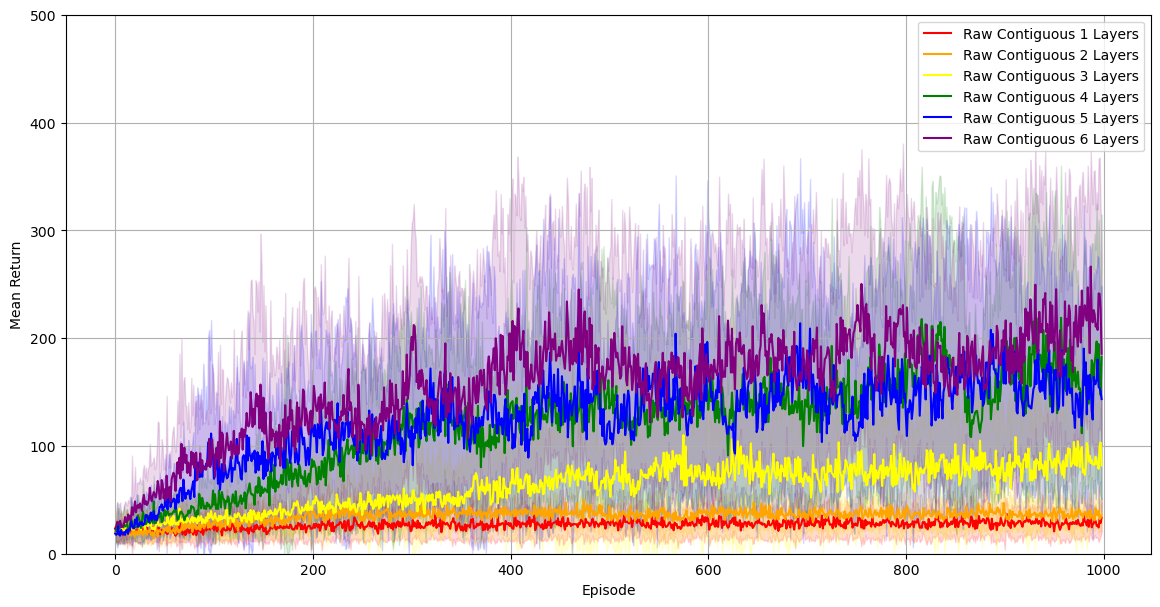

In [19]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(raw_contiguous_1layer_returns_mean,color = "red", label="Raw Contiguous 1 Layers")
plt.plot(raw_contiguous_2layer_returns_mean,color = "orange", label="Raw Contiguous 2 Layers")
plt.plot(raw_contiguous_3layer_returns_mean,color = "yellow", label="Raw Contiguous 3 Layers")
plt.plot(raw_contiguous_4layer_returns_mean,color = "green", label="Raw Contiguous 4 Layers")
plt.plot(raw_contiguous_5layer_returns_mean,color = "blue", label="Raw Contiguous 5 Layers")
plt.plot(raw_contiguous_6layer_returns_mean,color = "purple", label="Raw Contiguous 6 Layers")

plt.fill_between(np.arange(len(raw_contiguous_1layer_returns_mean)), np.clip(raw_contiguous_1layer_returns_mean - raw_contiguous_1layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_1layer_returns_mean + raw_contiguous_1layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="red")
plt.fill_between(np.arange(len(raw_contiguous_2layer_returns_mean)), np.clip(raw_contiguous_2layer_returns_mean - raw_contiguous_2layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_2layer_returns_mean + raw_contiguous_2layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="orange")
plt.fill_between(np.arange(len(raw_contiguous_1layer_returns_mean)), np.clip(raw_contiguous_3layer_returns_mean - raw_contiguous_3layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_3layer_returns_mean + raw_contiguous_3layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="yellow")
plt.fill_between(np.arange(len(raw_contiguous_4layer_returns_mean)), np.clip(raw_contiguous_4layer_returns_mean - raw_contiguous_4layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_4layer_returns_mean + raw_contiguous_4layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="green")
plt.fill_between(np.arange(len(raw_contiguous_5layer_returns_mean)), np.clip(raw_contiguous_5layer_returns_mean - raw_contiguous_5layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_5layer_returns_mean + raw_contiguous_5layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="blue")
plt.fill_between(np.arange(len(raw_contiguous_6layer_returns_mean)), np.clip(raw_contiguous_6layer_returns_mean - raw_contiguous_6layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_6layer_returns_mean + raw_contiguous_6layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="purple")

plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.ylim(0, 500)
plt.legend(loc = "upper right")
plt.grid(True)
#plt.savefig('../../graphs/skolik_baseline.pdf')  
plt.show()

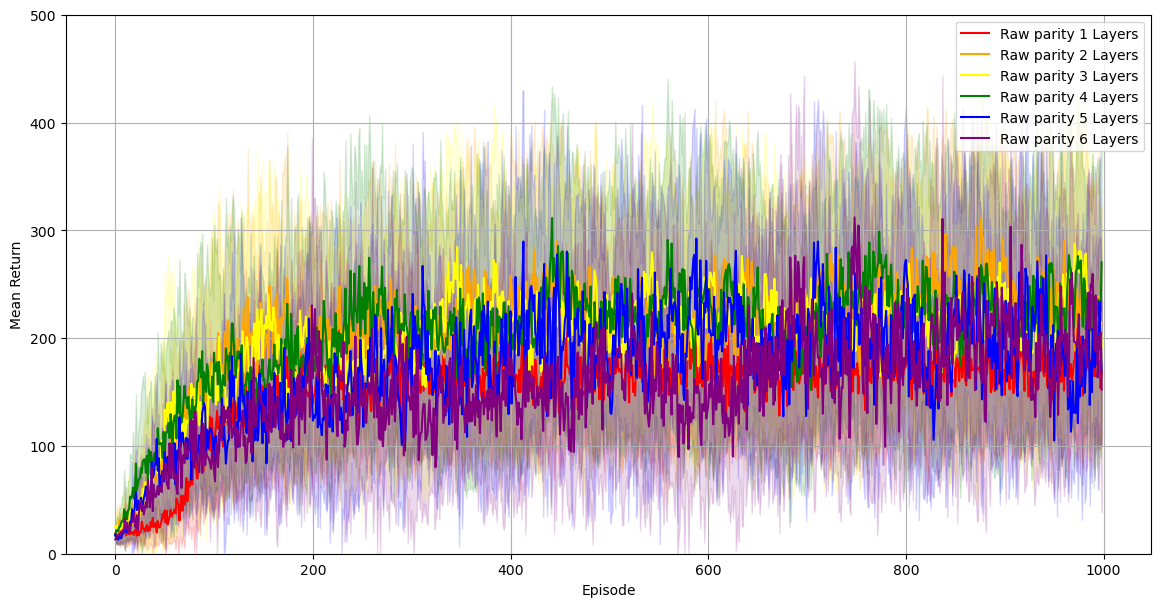

In [18]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(raw_parity_1layer_returns_mean,color = "red", label="Raw parity 1 Layers")
plt.plot(raw_parity_2layer_returns_mean,color = "orange", label="Raw parity 2 Layers")
plt.plot(raw_parity_3layer_returns_mean,color = "yellow", label="Raw parity 3 Layers")
plt.plot(raw_parity_4layer_returns_mean,color = "green", label="Raw parity 4 Layers")
plt.plot(raw_parity_5layer_returns_mean,color = "blue", label="Raw parity 5 Layers")
plt.plot(raw_parity_6layer_returns_mean,color = "purple", label="Raw parity 6 Layers")

plt.fill_between(np.arange(len(raw_parity_1layer_returns_mean)), np.clip(raw_parity_1layer_returns_mean - raw_parity_1layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_1layer_returns_mean + raw_parity_1layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="red")
plt.fill_between(np.arange(len(raw_parity_2layer_returns_mean)), np.clip(raw_parity_2layer_returns_mean - raw_parity_2layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_2layer_returns_mean + raw_parity_2layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="orange")
plt.fill_between(np.arange(len(raw_parity_1layer_returns_mean)), np.clip(raw_parity_3layer_returns_mean - raw_parity_3layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_3layer_returns_mean + raw_parity_3layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="yellow")
plt.fill_between(np.arange(len(raw_parity_4layer_returns_mean)), np.clip(raw_parity_4layer_returns_mean - raw_parity_4layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_4layer_returns_mean + raw_parity_4layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="green")
plt.fill_between(np.arange(len(raw_parity_5layer_returns_mean)), np.clip(raw_parity_5layer_returns_mean - raw_parity_5layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_5layer_returns_mean + raw_parity_5layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="blue")
plt.fill_between(np.arange(len(raw_parity_6layer_returns_mean)), np.clip(raw_parity_6layer_returns_mean - raw_parity_6layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_6layer_returns_mean + raw_parity_6layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="purple")

plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.legend(loc = "upper right")
plt.ylim(0, 500)
plt.grid(True)
#plt.savefig('../../graphs/skolik_baseline.pdf')  
plt.show()

## Episodes window average

In [20]:
raw_contiguous_1layer_returns_moving_average = raw_contiguous_1layer.get_moving_average()
raw_contiguous_2layer_returns_moving_average = raw_contiguous_2layer.get_moving_average()
raw_contiguous_3layer_returns_moving_average = raw_contiguous_3layer.get_moving_average()
raw_contiguous_4layer_returns_moving_average = raw_contiguous_4layer.get_moving_average()
raw_contiguous_5layer_returns_moving_average = raw_contiguous_5layer.get_moving_average()
raw_contiguous_6layer_returns_moving_average = raw_contiguous_6layer.get_moving_average()

raw_parity_1layer_returns_moving_average = raw_parity_1layer.get_moving_average()
raw_parity_2layer_returns_moving_average = raw_parity_2layer.get_moving_average()
raw_parity_3layer_returns_moving_average = raw_parity_3layer.get_moving_average()
raw_parity_4layer_returns_moving_average = raw_parity_4layer.get_moving_average()
raw_parity_5layer_returns_moving_average = raw_parity_5layer.get_moving_average()
raw_parity_6layer_returns_moving_average = raw_parity_6layer.get_moving_average()


raw_contiguous_1layer_returns_mean = np.mean(raw_contiguous_1layer_returns_moving_average, axis=0)
raw_contiguous_2layer_returns_mean = np.mean(raw_contiguous_2layer_returns_moving_average, axis=0)
raw_contiguous_3layer_returns_mean = np.mean(raw_contiguous_3layer_returns_moving_average, axis=0)
raw_contiguous_4layer_returns_mean = np.mean(raw_contiguous_4layer_returns_moving_average, axis=0)
raw_contiguous_5layer_returns_mean = np.mean(raw_contiguous_5layer_returns_moving_average, axis=0)
raw_contiguous_6layer_returns_mean = np.mean(raw_contiguous_6layer_returns_moving_average, axis=0)

raw_parity_1layer_returns_mean = np.mean(raw_parity_1layer_returns_moving_average, axis=0)
raw_parity_2layer_returns_mean = np.mean(raw_parity_2layer_returns_moving_average, axis=0)
raw_parity_3layer_returns_mean = np.mean(raw_parity_3layer_returns_moving_average, axis=0)
raw_parity_4layer_returns_mean = np.mean(raw_parity_4layer_returns_moving_average, axis=0)
raw_parity_5layer_returns_mean = np.mean(raw_parity_5layer_returns_moving_average, axis=0)
raw_parity_6layer_returns_mean = np.mean(raw_parity_6layer_returns_moving_average, axis=0)


raw_contiguous_1layer_returns_std = np.std(raw_contiguous_1layer_returns_moving_average, axis=0)
raw_contiguous_2layer_returns_std = np.std(raw_contiguous_2layer_returns_moving_average, axis=0)
raw_contiguous_3layer_returns_std = np.std(raw_contiguous_3layer_returns_moving_average, axis=0)
raw_contiguous_4layer_returns_std = np.std(raw_contiguous_4layer_returns_moving_average, axis=0)
raw_contiguous_5layer_returns_std = np.std(raw_contiguous_5layer_returns_moving_average, axis=0)
raw_contiguous_6layer_returns_std = np.std(raw_contiguous_6layer_returns_moving_average, axis=0)

raw_parity_1layer_returns_std = np.std(raw_parity_1layer_returns_moving_average, axis=0)
raw_parity_2layer_returns_std = np.std(raw_parity_2layer_returns_moving_average, axis=0)
raw_parity_3layer_returns_std = np.std(raw_parity_3layer_returns_moving_average, axis=0)
raw_parity_4layer_returns_std = np.std(raw_parity_4layer_returns_moving_average, axis=0)
raw_parity_5layer_returns_std = np.std(raw_parity_5layer_returns_moving_average, axis=0)
raw_parity_6layer_returns_std = np.std(raw_parity_6layer_returns_moving_average, axis=0)

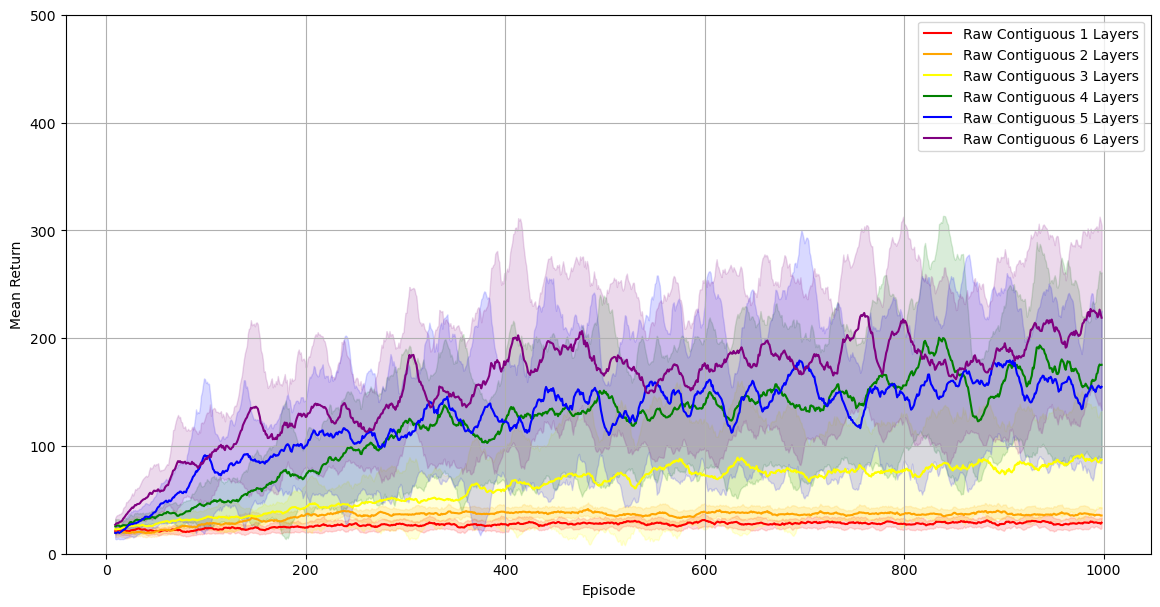

In [21]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(raw_contiguous_1layer_returns_mean,color = "red", label="Raw Contiguous 1 Layers")
plt.plot(raw_contiguous_2layer_returns_mean,color = "orange", label="Raw Contiguous 2 Layers")
plt.plot(raw_contiguous_3layer_returns_mean,color = "yellow", label="Raw Contiguous 3 Layers")
plt.plot(raw_contiguous_4layer_returns_mean,color = "green", label="Raw Contiguous 4 Layers")
plt.plot(raw_contiguous_5layer_returns_mean,color = "blue", label="Raw Contiguous 5 Layers")
plt.plot(raw_contiguous_6layer_returns_mean,color = "purple", label="Raw Contiguous 6 Layers")

plt.fill_between(np.arange(len(raw_contiguous_1layer_returns_mean)), np.clip(raw_contiguous_1layer_returns_mean - raw_contiguous_1layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_1layer_returns_mean + raw_contiguous_1layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="red")
plt.fill_between(np.arange(len(raw_contiguous_2layer_returns_mean)), np.clip(raw_contiguous_2layer_returns_mean - raw_contiguous_2layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_2layer_returns_mean + raw_contiguous_2layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="orange")
plt.fill_between(np.arange(len(raw_contiguous_1layer_returns_mean)), np.clip(raw_contiguous_3layer_returns_mean - raw_contiguous_3layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_3layer_returns_mean + raw_contiguous_3layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="yellow")
plt.fill_between(np.arange(len(raw_contiguous_4layer_returns_mean)), np.clip(raw_contiguous_4layer_returns_mean - raw_contiguous_4layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_4layer_returns_mean + raw_contiguous_4layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="green")
plt.fill_between(np.arange(len(raw_contiguous_5layer_returns_mean)), np.clip(raw_contiguous_5layer_returns_mean - raw_contiguous_5layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_5layer_returns_mean + raw_contiguous_5layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="blue")
plt.fill_between(np.arange(len(raw_contiguous_6layer_returns_mean)), np.clip(raw_contiguous_6layer_returns_mean - raw_contiguous_6layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_6layer_returns_mean + raw_contiguous_6layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="purple")

plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.ylim(0, 500)
plt.legend(loc = "upper right")
plt.grid(True)
#plt.savefig('../../graphs/skolik_baseline.pdf')  
plt.show()

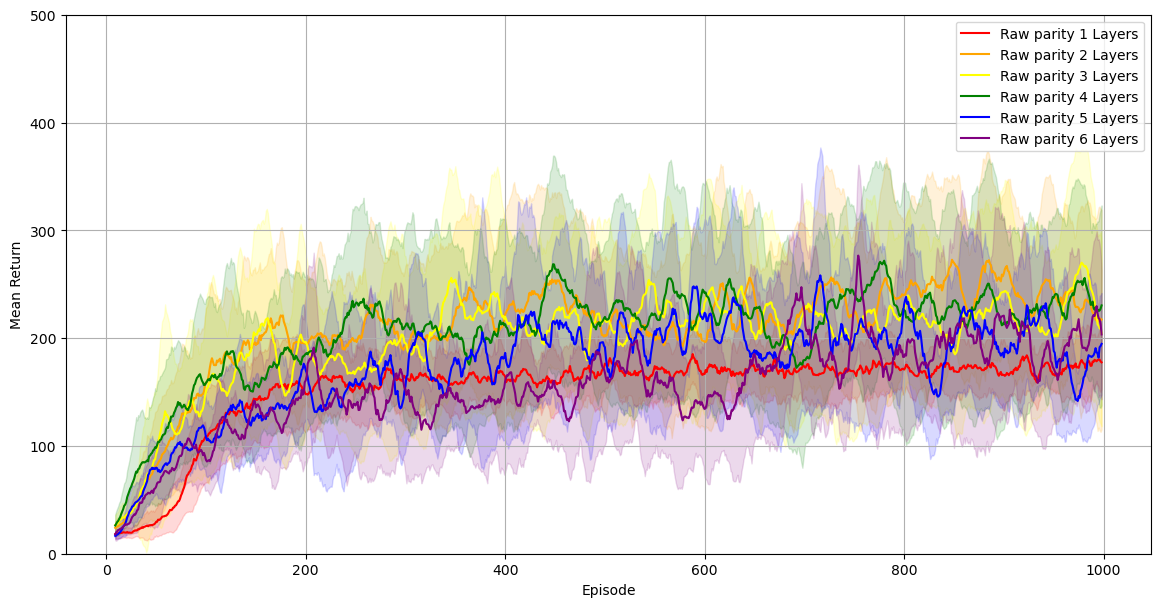

In [22]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(raw_parity_1layer_returns_mean,color = "red", label="Raw parity 1 Layers")
plt.plot(raw_parity_2layer_returns_mean,color = "orange", label="Raw parity 2 Layers")
plt.plot(raw_parity_3layer_returns_mean,color = "yellow", label="Raw parity 3 Layers")
plt.plot(raw_parity_4layer_returns_mean,color = "green", label="Raw parity 4 Layers")
plt.plot(raw_parity_5layer_returns_mean,color = "blue", label="Raw parity 5 Layers")
plt.plot(raw_parity_6layer_returns_mean,color = "purple", label="Raw parity 6 Layers")

plt.fill_between(np.arange(len(raw_parity_1layer_returns_mean)), np.clip(raw_parity_1layer_returns_mean - raw_parity_1layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_1layer_returns_mean + raw_parity_1layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="red")
plt.fill_between(np.arange(len(raw_parity_2layer_returns_mean)), np.clip(raw_parity_2layer_returns_mean - raw_parity_2layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_2layer_returns_mean + raw_parity_2layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="orange")
plt.fill_between(np.arange(len(raw_parity_1layer_returns_mean)), np.clip(raw_parity_3layer_returns_mean - raw_parity_3layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_3layer_returns_mean + raw_parity_3layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="yellow")
plt.fill_between(np.arange(len(raw_parity_4layer_returns_mean)), np.clip(raw_parity_4layer_returns_mean - raw_parity_4layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_4layer_returns_mean + raw_parity_4layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="green")
plt.fill_between(np.arange(len(raw_parity_5layer_returns_mean)), np.clip(raw_parity_5layer_returns_mean - raw_parity_5layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_5layer_returns_mean + raw_parity_5layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="blue")
plt.fill_between(np.arange(len(raw_parity_6layer_returns_mean)), np.clip(raw_parity_6layer_returns_mean - raw_parity_6layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_6layer_returns_mean + raw_parity_6layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="purple")

plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.legend(loc = "upper right")
plt.ylim(0, 500)
plt.grid(True)
#plt.savefig('../../graphs/skolik_baseline.pdf')  
plt.show()

## Gradients


In [ ]:
raw_contiguous_1layer_path = "../../../../data/CartPole-v1/test"
a = Analysis(raw_contiguous_1layer_path)

print((a.get_gradients()))
print(len(a.get_input_gradients()[0][2]))

b = a.calculate_mean_variance_gradients()

In [ ]:
raw_contiguous_1layer_gradients = raw_contiguous_1layer.calculate_mean_variance_gradients()
raw_contiguous_4layer_gradients = raw_contiguous_4layer.calculate_mean_variance_gradients()
raw_contiguous_6layer_gradients = raw_contiguous_6layer.calculate_mean_variance_gradients()
raw_contiguous_8layer_gradients = raw_contiguous_8layer.calculate_mean_variance_gradients()
#raw_parity_1layer_gradients = raw_parity_1layer.calculate_mean_variance_gradients()
raw_parity_4layer_gradients = raw_parity_4layer.calculate_mean_variance_gradients()
raw_parity_6layer_gradients = raw_parity_6layer.calculate_mean_variance_gradients()
#raw_parity_8layer_gradients = raw_parity_8layer.calculate_mean_variance_gradients()

raw_contiguous_1layer_input_gradients = raw_contiguous_1layer.calculate_mean_variance_input_gradients()
raw_contiguous_4layer_input_gradients = raw_contiguous_4layer.calculate_mean_variance_input_gradients()
raw_contiguous_6layer_input_gradients = raw_contiguous_6layer.calculate_mean_variance_input_gradients()
raw_contiguous_8layer_input_gradients = raw_contiguous_8layer.calculate_mean_variance_input_gradients()
#raw_parity_1layer_input_gradients = raw_parity_1layer.calculate_mean_variance_input_gradients()
raw_parity_4layer_input_gradients = raw_parity_4layer.calculate_mean_variance_input_gradients()
raw_parity_6layer_input_gradients = raw_parity_6layer.calculate_mean_variance_input_gradients()
#raw_parity_8layer_input_gradients = raw_parity_8layer.calculate_mean_variance_input_gradients()

# Output scaling and beta scheduling effects

In [9]:
softmax_path = "../../../../data/CartPole-v1/softmax_outputscaling_beta_tests/softmax"
softmax_beta_path = "../../../../data/CartPole-v1/softmax_outputscaling_beta_tests/softmax_betascheduling"
softmax_outputscaling_path = "../../../../data/CartPole-v1/softmax_outputscaling_beta_tests/softmax_outputscaling"
softmax_beta_outputscaling_path = "../../../../data/CartPole-v1/softmax_outputscaling_beta_tests/softmax_betascheduling_outputscaling"

softmax = Analysis(softmax_path)
softmax_beta = Analysis(softmax_beta_path)
softmax_outputscaling = Analysis(softmax_outputscaling_path)
softmax_beta_outputscaling = Analysis(softmax_beta_outputscaling_path)

In [10]:
softmax_returns = softmax.get_rewards()
softmax_beta_returns = softmax_beta.get_rewards()
softmax_outputscaling_returns = softmax_outputscaling.get_rewards()
softmax_beta_outputscaling_returns = softmax_beta_outputscaling.get_rewards()


softmax_returns_mean = np.mean(softmax_returns, axis=0)
softmax_beta_returns_mean = np.mean(softmax_beta_returns, axis=0)
softmax_outputscaling_returns_mean = np.mean(softmax_outputscaling_returns, axis=0)
softmax_beta_outputscaling_returns_mean = np.mean(softmax_beta_outputscaling_returns, axis=0)


softmax_returns_std = np.std(softmax_returns, axis=0)
softmax_beta_returns_std = np.std(softmax_beta_returns, axis=0)
softmax_outputscaling_returns_std = np.std(softmax_outputscaling_returns, axis=0)
softmax_beta_outputscaling_returns_std = np.std(softmax_beta_outputscaling_returns, axis=0)

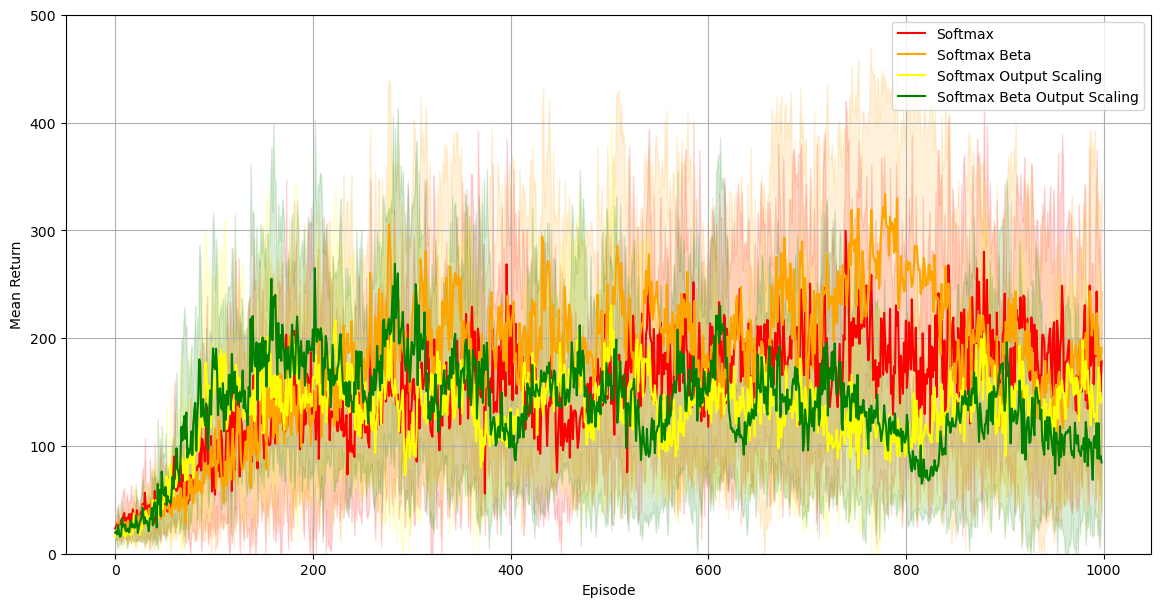

In [11]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(softmax_returns_mean,color = "red", label="Softmax")
plt.plot(softmax_beta_returns_mean,color = "orange", label="Softmax w/ Beta Scheduling")
plt.plot(softmax_outputscaling_returns_mean,color = "yellow", label="Softmax w/ Output Scaling")
plt.plot(softmax_beta_outputscaling_returns_mean,color = "green", label="Softmax w/ Beta Scheduling and Output Scaling")


plt.fill_between(np.arange(len(softmax_returns_mean)), 
                 np.clip(softmax_returns_mean - softmax_returns_std, a_min=0, a_max=500), 
                 np.clip(softmax_returns_mean + softmax_returns_std, a_min=None, a_max=500), 
                 alpha=0.15, color="red")

plt.fill_between(np.arange(len(softmax_beta_returns_mean)), 
                 np.clip(softmax_beta_returns_mean - softmax_beta_returns_std, a_min=0, a_max=500), 
                 np.clip(softmax_beta_returns_mean + softmax_beta_returns_std, a_min=None, a_max=500), 
                 alpha=0.15, color="orange")

plt.fill_between(np.arange(len(softmax_outputscaling_returns_mean)), 
                 np.clip(softmax_outputscaling_returns_mean - softmax_outputscaling_returns_std, a_min=0, a_max=500), 
                 np.clip(softmax_outputscaling_returns_mean + softmax_outputscaling_returns_std, a_min=None, a_max=500), 
                 alpha=0.15, color="yellow")

plt.fill_between(np.arange(len(softmax_beta_outputscaling_returns_mean)), 
                 np.clip(softmax_beta_outputscaling_returns_mean - softmax_beta_outputscaling_returns_std, a_min=0, a_max=500), 
                 np.clip(softmax_beta_outputscaling_returns_mean + softmax_beta_outputscaling_returns_std, a_min=None, a_max=500), 
                 alpha=0.15, color="green")

plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.ylim(0, 500)
plt.legend(loc = "upper right")
plt.grid(True)
#plt.savefig('../../graphs/skolik_baseline.pdf')  
plt.show()

In [12]:
softmax_returns_moving_average = softmax.get_moving_average()
softmax_beta_returns_moving_average = softmax_beta.get_moving_average()
softmax_outputscaling_returns_moving_average = softmax_outputscaling.get_moving_average()
softmax_beta_outputscaling_returns_moving_average = softmax_beta_outputscaling.get_moving_average()


softmax_returns_mean = np.mean(softmax_returns_moving_average, axis=0)
softmax_beta_returns_mean = np.mean(softmax_beta_returns_moving_average, axis=0)
softmax_outputscaling_returns_mean = np.mean(softmax_outputscaling_returns_moving_average, axis=0)
softmax_beta_outputscaling_returns_mean = np.mean(softmax_beta_outputscaling_returns_moving_average, axis=0)


softmax_returns_std = np.std(softmax_returns_moving_average, axis=0)
softmax_beta_returns_std = np.std(softmax_beta_returns_moving_average, axis=0)
softmax_outputscaling_returns_std = np.std(softmax_outputscaling_returns_moving_average, axis=0)
softmax_beta_outputscaling_returns_std = np.std(softmax_beta_outputscaling_returns_moving_average, axis=0)

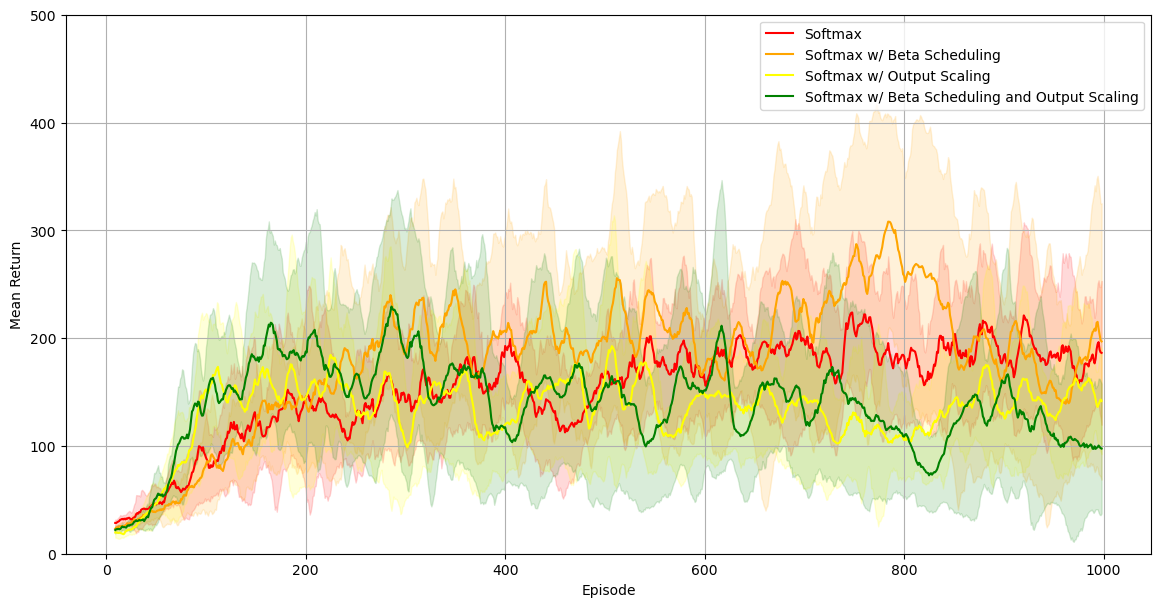

In [14]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(softmax_returns_mean,color = "red", label="Softmax")
plt.plot(softmax_beta_returns_mean,color = "orange", label="Softmax w/ Beta Scheduling")
plt.plot(softmax_outputscaling_returns_mean,color = "yellow", label="Softmax w/ Output Scaling")
plt.plot(softmax_beta_outputscaling_returns_mean,color = "green", label="Softmax w/ Beta Scheduling and Output Scaling")


plt.fill_between(np.arange(len(softmax_returns_mean)), 
                 np.clip(softmax_returns_mean - softmax_returns_std, a_min=0, a_max=500), 
                 np.clip(softmax_returns_mean + softmax_returns_std, a_min=None, a_max=500), 
                 alpha=0.15, color="red")

plt.fill_between(np.arange(len(softmax_beta_returns_mean)), 
                 np.clip(softmax_beta_returns_mean - softmax_beta_returns_std, a_min=0, a_max=500), 
                 np.clip(softmax_beta_returns_mean + softmax_beta_returns_std, a_min=None, a_max=500), 
                 alpha=0.15, color="orange")

plt.fill_between(np.arange(len(softmax_outputscaling_returns_mean)), 
                 np.clip(softmax_outputscaling_returns_mean - softmax_outputscaling_returns_std, a_min=0, a_max=500), 
                 np.clip(softmax_outputscaling_returns_mean + softmax_outputscaling_returns_std, a_min=None, a_max=500), 
                 alpha=0.15, color="yellow")

plt.fill_between(np.arange(len(softmax_beta_outputscaling_returns_mean)), 
                 np.clip(softmax_beta_outputscaling_returns_mean - softmax_beta_outputscaling_returns_std, a_min=0, a_max=500), 
                 np.clip(softmax_beta_outputscaling_returns_mean + softmax_beta_outputscaling_returns_std, a_min=None, a_max=500), 
                 alpha=0.15, color="green")

plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.ylim(0, 500)
plt.legend(loc = "upper right")
plt.grid(True)
#plt.savefig('../../graphs/skolik_baseline.pdf')  
plt.show()

# Amsgrad On vs Off


In [15]:
raw_parity_amsgrad_on_path = "../../../../data/CartPole-v1/raw_parity_variable_learning_rates_with-out_amsgrad/raw_parity_4layer_amsgrad_on"
raw_parity_amsgrad_off_path = "../../../../data/CartPole-v1/raw_parity_variable_learning_rates_with-out_amsgrad/raw_parity_4layer_amsgrad_off"


raw_parity_amsgrad_on = Analysis(raw_parity_amsgrad_on_path)
raw_parity_amsgrad_off = Analysis(raw_parity_amsgrad_off_path)

In [16]:
raw_parity_amsgrad_on_returns = raw_parity_amsgrad_on.get_rewards()
raw_parity_amsgrad_off_returns = raw_parity_amsgrad_off.get_rewards()


raw_parity_amsgrad_on_returns_mean = np.mean(raw_parity_amsgrad_on_returns, axis=0)
raw_parity_amsgrad_off_returns_mean = np.mean(raw_parity_amsgrad_off_returns, axis=0)


raw_parity_amsgrad_on_returns_std = np.std(raw_parity_amsgrad_on_returns, axis=0)
raw_parity_amsgrad_off_returns_std = np.std(raw_parity_amsgrad_off_returns, axis=0)

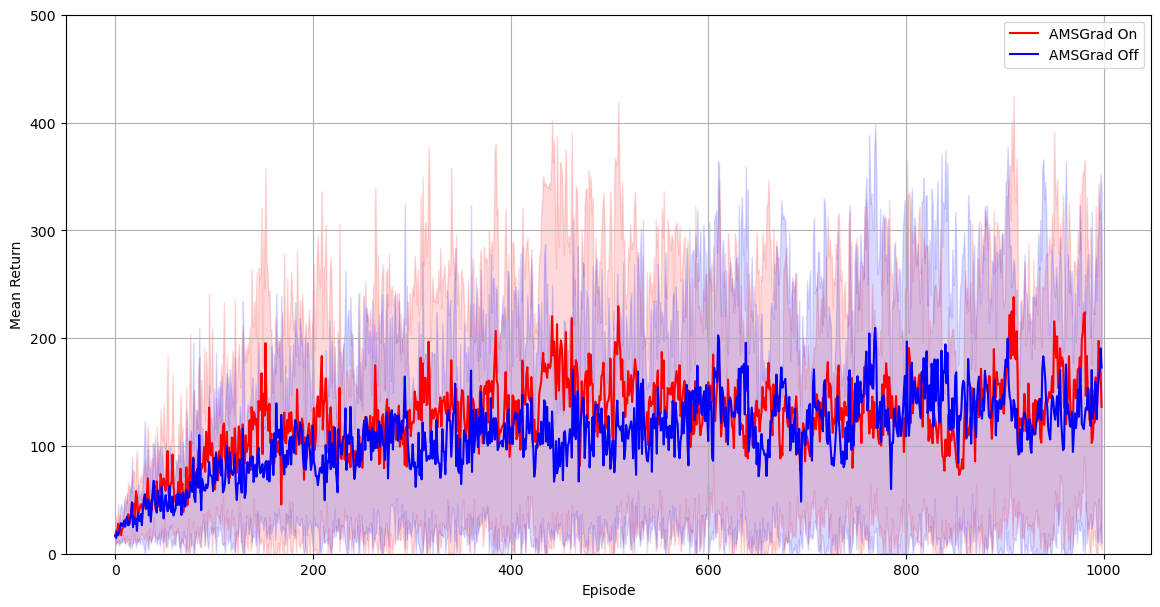

In [17]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(raw_parity_amsgrad_on_returns_mean, color="red", label="AMSGrad On")
plt.plot(raw_parity_amsgrad_off_returns_mean, color="blue", label="AMSGrad Off")

plt.fill_between(np.arange(len(raw_parity_amsgrad_on_returns_mean)), 
                 np.clip(raw_parity_amsgrad_on_returns_mean - raw_parity_amsgrad_on_returns_std, a_min=0, a_max=500), 
                 np.clip(raw_parity_amsgrad_on_returns_mean + raw_parity_amsgrad_on_returns_std, a_min=0, a_max=500), 
                 alpha=0.15, color="red")

plt.fill_between(np.arange(len(raw_parity_amsgrad_off_returns_mean)), 
                 np.clip(raw_parity_amsgrad_off_returns_mean - raw_parity_amsgrad_off_returns_std, a_min=0, a_max=500), 
                 np.clip(raw_parity_amsgrad_off_returns_mean + raw_parity_amsgrad_off_returns_std, a_min=0, a_max=500), 
                 alpha=0.15, color="blue")

plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.ylim(0, 500)
plt.legend(loc="upper right")
plt.grid(True)

#plt.savefig('../../graphs/skolik_baseline.pdf')
plt.show()

# Softmax schedules

In [19]:
softmax_smart_path = "../../../../data/CartPole-v1/softmax_schedules/softmax_smart_schedule"
softmax_linear_path = "../../../../data/CartPole-v1/softmax_schedules/softmax_linear_schedule"


softmax_smart = Analysis(softmax_smart_path)
softmax_linear = Analysis(softmax_linear_path)

In [20]:
softmax_smart_returns = raw_parity_amsgrad_on.get_rewards()
softmax_linear_returns = softmax_linear.get_rewards()


softmax_smart_returns_mean = np.mean(softmax_smart_returns, axis=0)
softmax_linear_returns_mean = np.mean(softmax_linear_returns, axis=0)


softmax_smart_returns_std = np.std(softmax_smart_returns, axis=0)
softmax_linear_returns_std = np.std(softmax_linear_returns, axis=0)

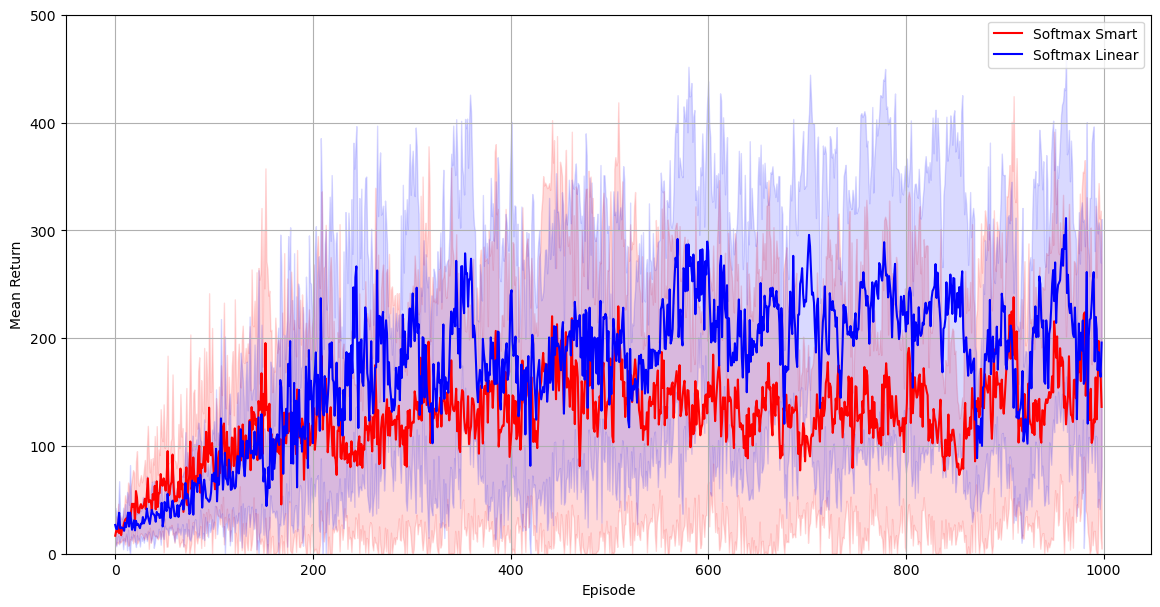

In [21]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(softmax_smart_returns_mean, color="red", label="Softmax Smart")
plt.plot(softmax_linear_returns_mean, color="blue", label="Softmax Linear")

plt.fill_between(np.arange(len(softmax_smart_returns_mean)), 
                 np.clip(softmax_smart_returns_mean - softmax_smart_returns_std, a_min=0, a_max=500), 
                 np.clip(softmax_smart_returns_mean + softmax_smart_returns_std, a_min=0, a_max=500), 
                 alpha=0.15, color="red")

plt.fill_between(np.arange(len(softmax_linear_returns_mean)), 
                 np.clip(softmax_linear_returns_mean - softmax_linear_returns_std, a_min=0, a_max=500), 
                 np.clip(softmax_linear_returns_mean + softmax_linear_returns_std, a_min=0, a_max=500), 
                 alpha=0.15, color="blue")

plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.ylim(0, 500)
plt.legend(loc="upper right")
plt.grid(True)

#plt.savefig('../../graphs/skolik_baseline.pdf')
plt.show()

In [22]:
softmax_smart_returns_moving_average = raw_parity_amsgrad_on.get_moving_average()
softmax_linear_returns_moving_average = softmax_linear.get_moving_average()


softmax_smart_returns_mean = np.mean(softmax_smart_returns_moving_average, axis=0)
softmax_linear_returns_mean = np.mean(softmax_linear_returns_moving_average, axis=0)


softmax_smart_returns_std = np.std(softmax_smart_returns_moving_average, axis=0)
softmax_linear_returns_std = np.std(softmax_linear_returns_moving_average, axis=0)

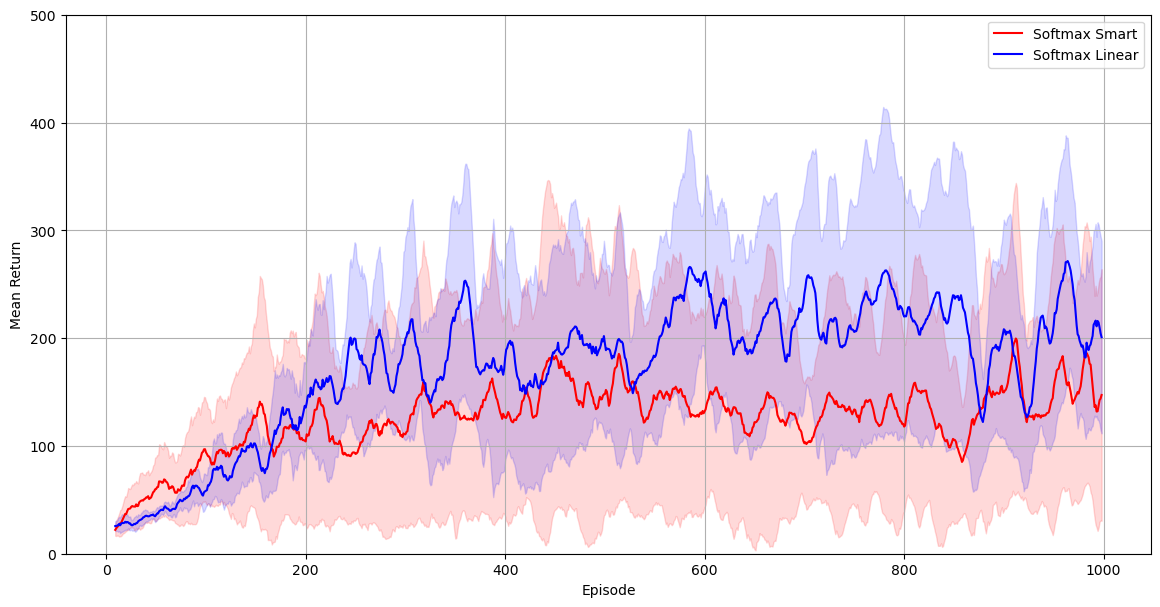

In [23]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(softmax_smart_returns_mean, color="red", label="Softmax Smart")
plt.plot(softmax_linear_returns_mean, color="blue", label="Softmax Linear")

plt.fill_between(np.arange(len(softmax_smart_returns_mean)), 
                 np.clip(softmax_smart_returns_mean - softmax_smart_returns_std, a_min=0, a_max=500), 
                 np.clip(softmax_smart_returns_mean + softmax_smart_returns_std, a_min=0, a_max=500), 
                 alpha=0.15, color="red")

plt.fill_between(np.arange(len(softmax_linear_returns_mean)), 
                 np.clip(softmax_linear_returns_mean - softmax_linear_returns_std, a_min=0, a_max=500), 
                 np.clip(softmax_linear_returns_mean + softmax_linear_returns_std, a_min=0, a_max=500), 
                 alpha=0.15, color="blue")

plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.ylim(0, 500)
plt.legend(loc="upper right")
plt.grid(True)

#plt.savefig('../../graphs/skolik_baseline.pdf')
plt.show()